In [1]:
# default_exp reflect

# Reflect

https://youtu.be/8Uo6zFwSO78?list=WL&t=2164

https://www.instagram.com/p/Bv3fVt8nq-4/

Should try and use IPyCanvas - https://ipycanvas.readthedocs.io/en/latest/styles_and_colors.html?highlight=gradient#color-gradients

<br>

### Imports

In [2]:
import numpy as np

import colorsys
import seaborn as sns
import matplotlib.pyplot as plt

from ipycanvas import Canvas

In [3]:
def get_xy_pos(width=500, height=300):
    x = np.arange(width+1)
    y = np.arange(height+1)

    XX, YY = np.meshgrid(x, y)

    xy_pos = np.array([XX.reshape(-1), YY.reshape(-1)]).T
    
    return xy_pos

width = 500
height = 300

xy_pos = get_xy_pos(width, height)

xy_pos.shape

(150801, 2)

<br>

Next we need to create the three points that will be used for drawing the two line segments

In [12]:
a, b, c = np.random.uniform(size=(3, 2)) * np.array([width, height])

a, b, c

(array([434.31460278, 214.90001059]),
 array([452.75061872,  39.13243184]),
 array([129.80819917,  83.50727542]))

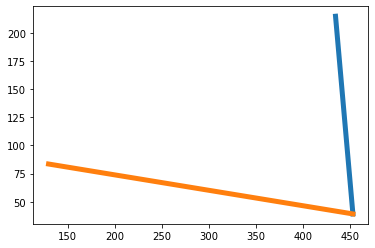

In [13]:
points_to_line = lambda p1, p2: [(p1[0], p2[0]), (p1[1], p2[1])]

plt.plot(*points_to_line(a, b), color='C0', linewidth=5)
plt.plot(*points_to_line(b, c), color='C1', linewidth=5)

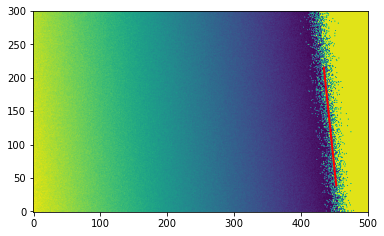

In [14]:
calc_dir_dist_to_line = lambda lp0, lp1, points: np.cross(lp1-lp0, lp0-points) / np.linalg.norm(lp1-lp0)
normalise_data = lambda x: (x-min(x))/(max(x)-min(x))

def calc_adj_dist_to_line(lp0, lp1, points, dist_factor=1, noise_factor=10, normalise=True):
    dir_dist = calc_dir_dist_to_line(lp0, lp1, points)    
    noise = np.random.normal(scale=noise_factor, size=len(dir_dist))
    
    max_dist = dir_dist.max()
    adj_dist = dir_dist/dist_factor + noise
    adj_dist = np.where(adj_dist<0, max_dist, adj_dist)
    
    if normalise == True:
        adj_dist = normalise_data(adj_dist)
    
    return adj_dist

adj_dist = calc_adj_dist_to_line(a, b, xy_pos)

plt.imshow(adj_dist.reshape((height+1, width+1)), origin='lower')
plt.plot(*points_to_line(a, b), color='r', linewidth=2)

<br>

We now want to create a colour gradient based on the distance that goes from dark to light for a specified colour. Within this we'll convert from Red, Green, and Blue (RGB) to Hue, Lightness, and Saturation (HLS) which will allow us to control the brightness more intuitively.

In [15]:
def get_var_lightness_rgb(rgb_base=(0.51, 0.51, 0.78), lightness_vals=None, lightness_floor=0, lightness_ceil=0.5):
    hls_base = colorsys.rgb_to_hls(*rgb_base)
    
    if lightness_vals is None:
        lightness_vals = np.linspace(lightness_floor, lightness_ceil, 10)
    else:
        lightness_vals = lightness_vals*(lightness_ceil-lightness_floor) + lightness_floor
        
    rgb_vals = [colorsys.hls_to_rgb(hls_base[0], lightness_val, hls_base[2]) for lightness_val in lightness_vals]

    return rgb_vals

rgb_vals = get_var_lightness_rgb()

sns.color_palette(rgb_vals)

[(0.0, 0.0, 0.0),
 (0.03442879499217527, 0.03442879499217527, 0.07668231611893583),
 (0.06885758998435054, 0.06885758998435054, 0.15336463223787167),
 (0.10328638497652581, 0.10328638497652581, 0.2300469483568075),
 (0.13771517996870108, 0.13771517996870108, 0.30672926447574334),
 (0.1721439749608764, 0.1721439749608764, 0.38341158059467917),
 (0.20657276995305163, 0.20657276995305163, 0.460093896713615),
 (0.24100156494522695, 0.24100156494522695, 0.5367762128325507),
 (0.27543035993740217, 0.27543035993740217, 0.6134585289514867),
 (0.3098591549295775, 0.3098591549295775, 0.6901408450704225)]

In [16]:
def points_line_to_rgb_stack(lp0, lp1, width=500, height=300, dist_factor=1, noise_factor=20, normalise=True, rgb_base=(0.51, 0.51, 0.78)):
    xy_pos = get_xy_pos(width, height)

    adj_dist = calc_adj_dist_to_line(lp0, lp1, xy_pos, dist_factor=dist_factor, noise_factor=noise_factor, normalise=normalise)
    rgb_vals = get_var_lightness_rgb(rgb_base, lightness_vals=1-adj_dist)
    rgb_stack = np.array(rgb_vals).reshape((width+1, height+1, 3), order='F')
    #rgb_stack = np.array(rgb_vals).T.reshape(3, XX.shape[0], XX.shape[1]).T
    
    return rgb_stack

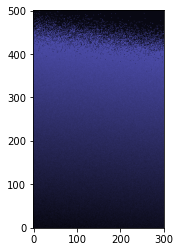

In [17]:
rgb_stack = points_line_to_rgb_stack(a, b)

plt.imshow(rgb_stack, origin='lower')

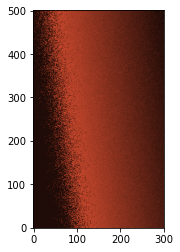

In [18]:
rgb_base = (0.839, 0.373, 0.275)

rgb_stack = points_line_to_rgb_stack(b, c, rgb_base=rgb_base)

plt.imshow(rgb_stack, origin='lower')

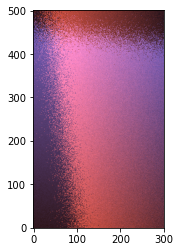

In [19]:
rgb_stack_a = points_line_to_rgb_stack(a, b)
rgb_stack_b = points_line_to_rgb_stack(b, c, rgb_base=rgb_base)

merged_rgb_stack = (rgb_stack_a + rgb_stack_b).clip(0, 1)

plt.imshow(merged_rgb_stack, origin='lower')